## Подключение необходимых библиотек и функций

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
import plotly.express as px
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, rand_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering, SpectralClustering


import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.datasets import load_iris
iris = load_iris()
df_iris_v2 = pd.DataFrame(iris.data)
# Делаем имена колонок такие же, как имена переменных:
df_iris_v2.columns = iris.feature_names
# Добавляем столбец с целевой переменной: 
df_iris_v2['class'] = iris.target
y = df_iris_v2.iloc[:, 0]
df_iris = pd.DataFrame(iris.data)
df_iris.columns = iris.feature_names
df_iris.head()

sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                5.1               3.5                1.4               0.2
1                4.9               3.0                1.4               0.2
2                4.7               3.2                1.3               0.2
3                4.6               3.1                1.5               0.2
4                5.0               3.6                1.4               0.2

# Разведочный анализ

In [4]:
df_iris.describe()

sepal length (cm)  sepal width (cm)  petal length (cm)  \
count         150.000000        150.000000         150.000000   
mean            5.843333          3.057333           3.758000   
std             0.828066          0.435866           1.765298   
min             4.300000          2.000000           1.000000   
25%             5.100000          2.800000           1.600000   
50%             5.800000          3.000000           4.350000   
75%             6.400000          3.300000           5.100000   
max             7.900000          4.400000           6.900000   

       petal width (cm)  
count        150.000000  
mean           1.199333  
std            0.762238  
min            0.100000  
25%            0.300000  
50%            1.300000  
75%            1.800000  
max            2.500000

In [5]:
pd.concat([df_iris.dtypes,df_iris.nunique()], axis=1).rename(columns={0: "Type", 1: "Number of unique"})

Type  Number of unique
sepal length (cm)  float64                35
sepal width (cm)   float64                23
petal length (cm)  float64                43
petal width (cm)   float64                22

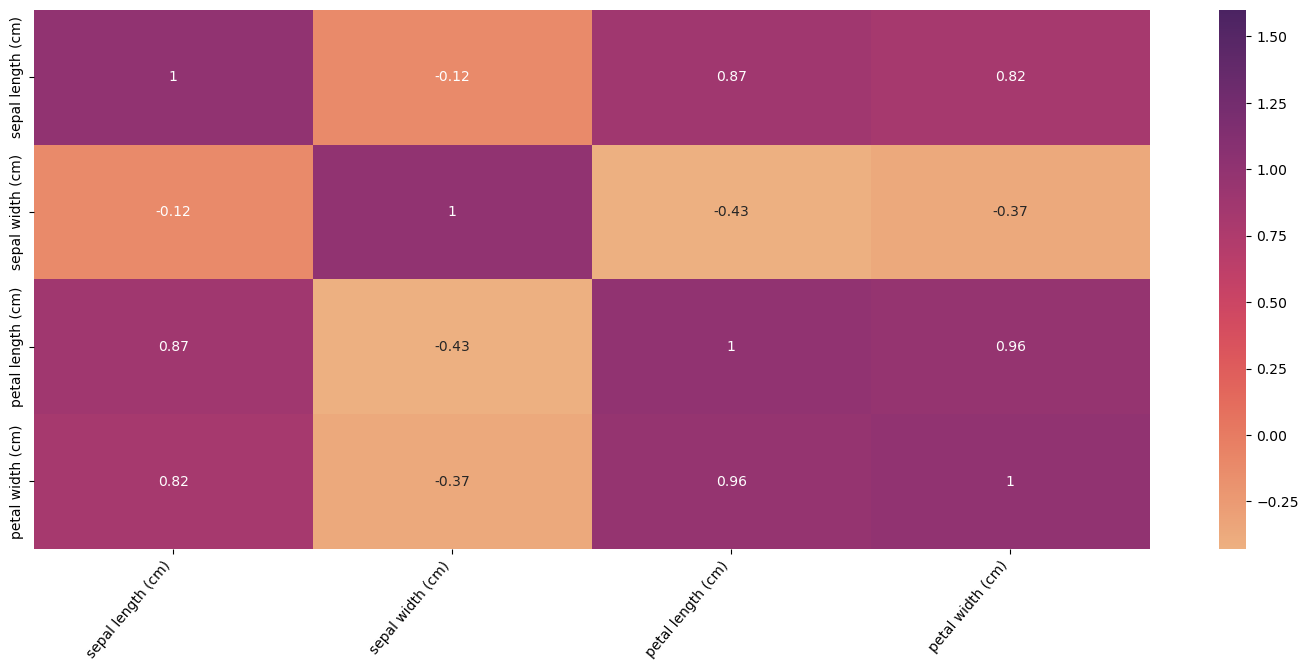

In [6]:
plt.figure(figsize = (18,7))
sns.heatmap(df_iris.corr(),cmap = sns.color_palette("flare", as_cmap=True),annot = True,vmax = 1.6);
plt.xticks(rotation=50, ha='right');

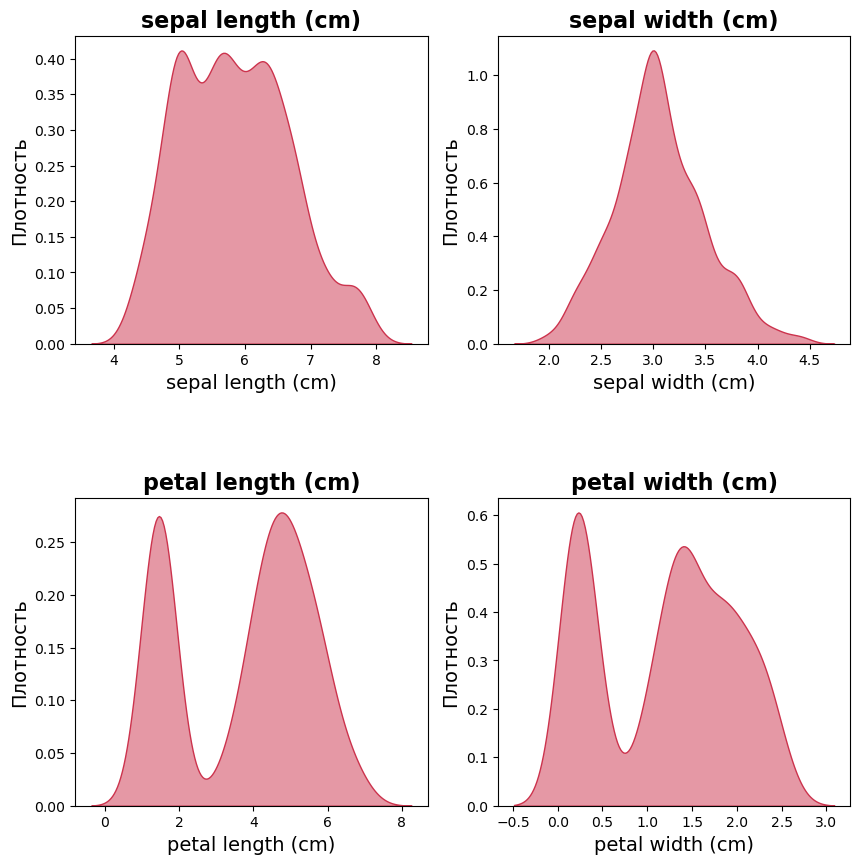

In [7]:
# Создаем матрицу графиков для визуализации распредления по каждой переменной
fig, axes = plt.subplots(2,2, figsize = (10,10))

# Расстояние между графиками
plt.subplots_adjust(hspace=0.5)

# Список значений признаков для цикла
columns = df_iris.columns

# Строим распределения (kdeplot) для каждого признака
for i, column in enumerate(columns):
    ax = axes[i // 2, i % 2]
    sns.kdeplot(data = df_iris,
                x = column,
                fill = True,
                alpha = 0.5,
                bw_adjust=.7,
                color = [0.8, 0.2, 0.3],
                ax = ax)
    
    ax.set_title(column, fontweight = 'bold', fontsize = 16)
    ax.set_xlabel(column, fontsize = 14)
    ax.set_ylabel('Плотность', fontsize = 14)
    

plt.show()

## Нормализация

In [9]:
mms = MinMaxScaler()
X=pd.DataFrame(mms.fit_transform(df_iris), columns=df_iris.columns)

## Метод главных компонент

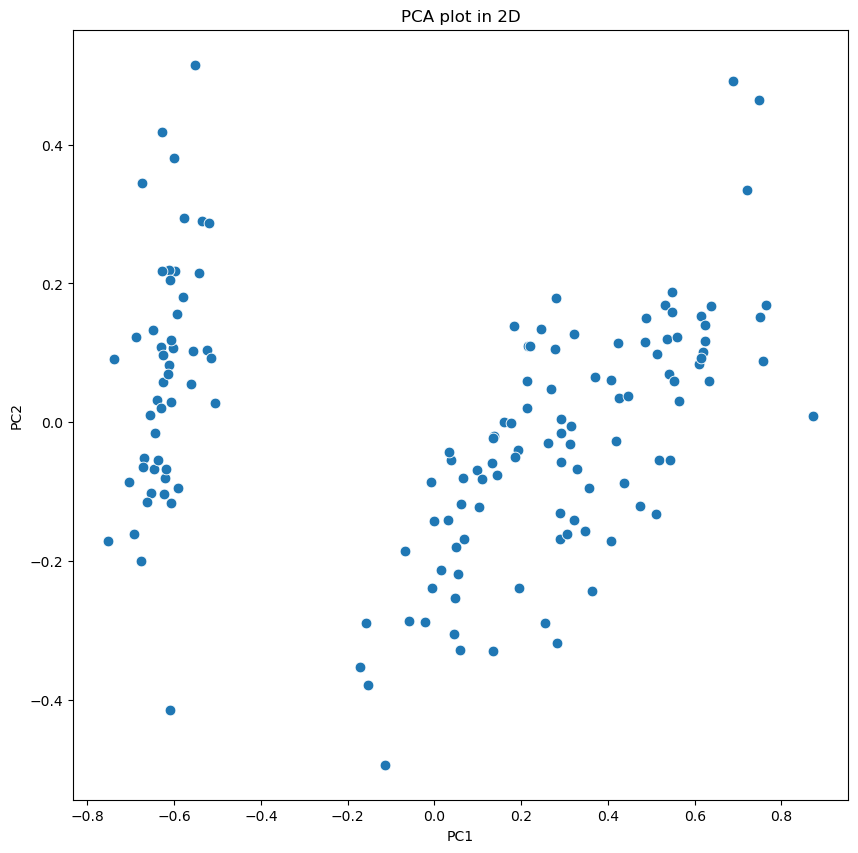

In [11]:
principal_df = pd.DataFrame(data = PCA(n_components=2).fit_transform(X))
    
fig = plt.figure(figsize=(10, 10))
sns.scatterplot(x = principal_df.iloc[:,0], 
                y = principal_df.iloc[:,1], 
                s=60)

plt.title('PCA plot in 2D')
plt.xlabel('PC1')
plt.ylabel('PC2');

In [12]:
def TSNEplot(pred=None):    
    tsne = TSNE(random_state=1)

    X_tsne = tsne.fit_transform(X)

    plt.figure(figsize=(12, 10))
    plt.scatter(X_tsne[:, 0], 
                X_tsne[:, 1], 
                c = pred, 
                edgecolor="none", 
                alpha=0.7, s=40,
        cmap=plt.cm.get_cmap("flare", 3))

    plt.colorbar()
    plt.title("t-SNE projection");

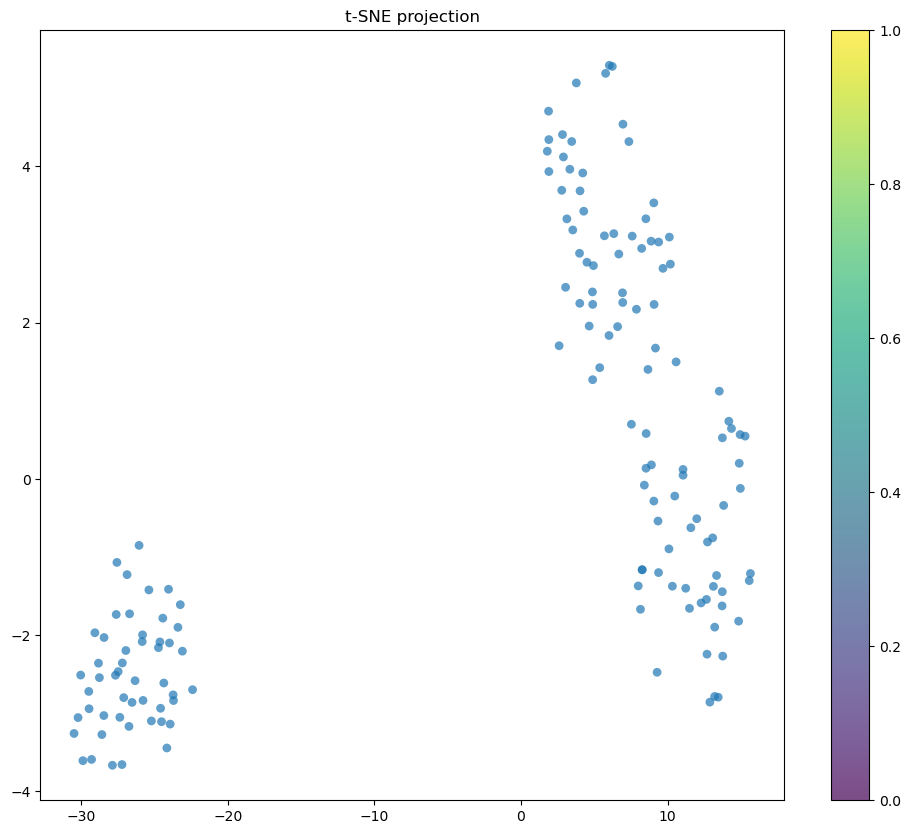

In [13]:
TSNEplot()

In [14]:
def PCAplot3D(x_data, y_data=None):
    components = PCA(n_components=3).fit_transform(x_data)

    fig = px.scatter_3d(
        components, 
        x=0, y=1, z=2, 
        color=y_data, 
        size=0.1*np.ones(len(X)), 
        opacity = 1,
        title='PCA plot in 3D',
        labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'},
        width=900, height=900
    )
    fig.show()

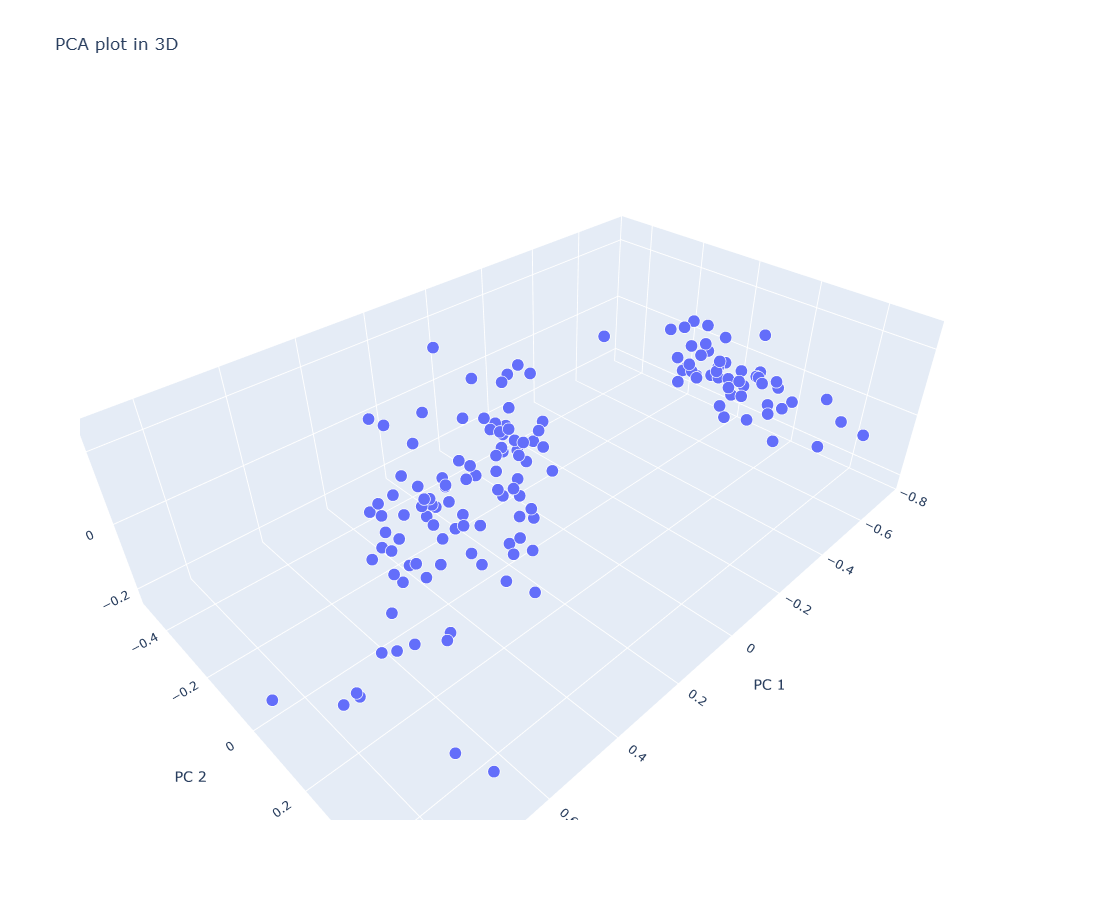

In [15]:
PCAplot3D(X)

# Обучение моделей

### Выбор метода кластеризации


Кластеризация ассоциируется с методом k-средних. Однако он не являтся единственным, только в библиотеке scikit-learn представлено 11 методов, некоторые из них могут решать общие задачи, другие - лучше справятся с определенным типом. 


В данном случае известно следущее: 
- Набор данных разбит на 3 класса
- Количество данных не слишком велико</li>
- При визуальном осмотре можно выделить 3 кластера 
- Проекция на плоскость имеет достаточно большую дисперсию

Выбор пал на методы K-Means, Spectral Clustering и Agglomerative Clustering by Ward. Главным параметром у них является число кластеров, а на графике распределения, схожим с нашим, методы демонстрируют достаточно хорошую работу.

## K-Means

In [18]:
pca = PCA(n_components=2)

kmeans = KMeans(n_clusters=3, random_state=1, n_init='auto').fit(X)
centroids_pca = pca.fit_transform(kmeans.cluster_centers_)
pred_k = kmeans.labels_

principal_df = pd.DataFrame(data = PCA(n_components=2).fit_transform(X))

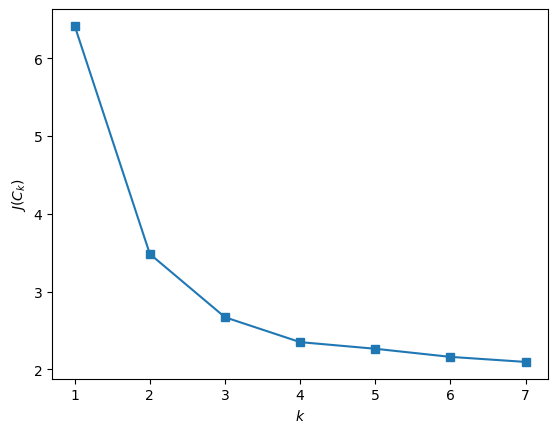

In [19]:
inertia = []
for k in range(1, 8):
    kmeans = KMeans(n_clusters=k, random_state=1, n_init='auto').fit(X)
    inertia.append(np.sqrt(kmeans.inertia_))
    
plt.plot(range(1, 8), inertia, marker="s")
plt.xlabel("$k$")
plt.ylabel("$J(C_k)$");

Количество кластеров берём 3, так как видно перегиб на значение 3.

In [20]:
pca = PCA(n_components=2)


kmeans = KMeans(n_clusters=3, random_state=1, n_init='auto').fit(X)
centroids_pca = pca.fit_transform(kmeans.cluster_centers_)
pred_k = kmeans.labels_

principal_df = pd.DataFrame(data = PCA(n_components=2).fit_transform(X))

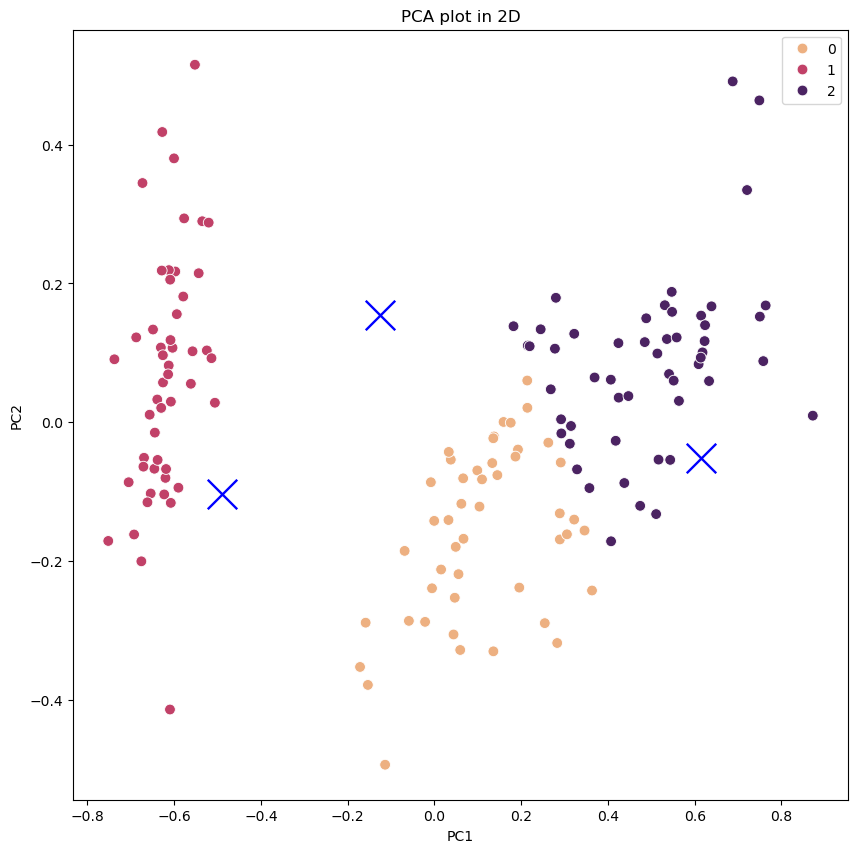

In [21]:
fig = plt.figure(figsize=(10, 10))
sns.scatterplot(x = principal_df.iloc[:,0], 
                y = principal_df.iloc[:,1], 
                hue = pred_k, 
                palette="flare", 
                s=60)
sns.scatterplot(x = centroids_pca[:,0], 
                y =  centroids_pca[:,1],  
                marker="x", 
                s=450, 
                color = 'blue')
plt.title('PCA plot in 2D')
plt.xlabel('PC1')
plt.ylabel('PC2');

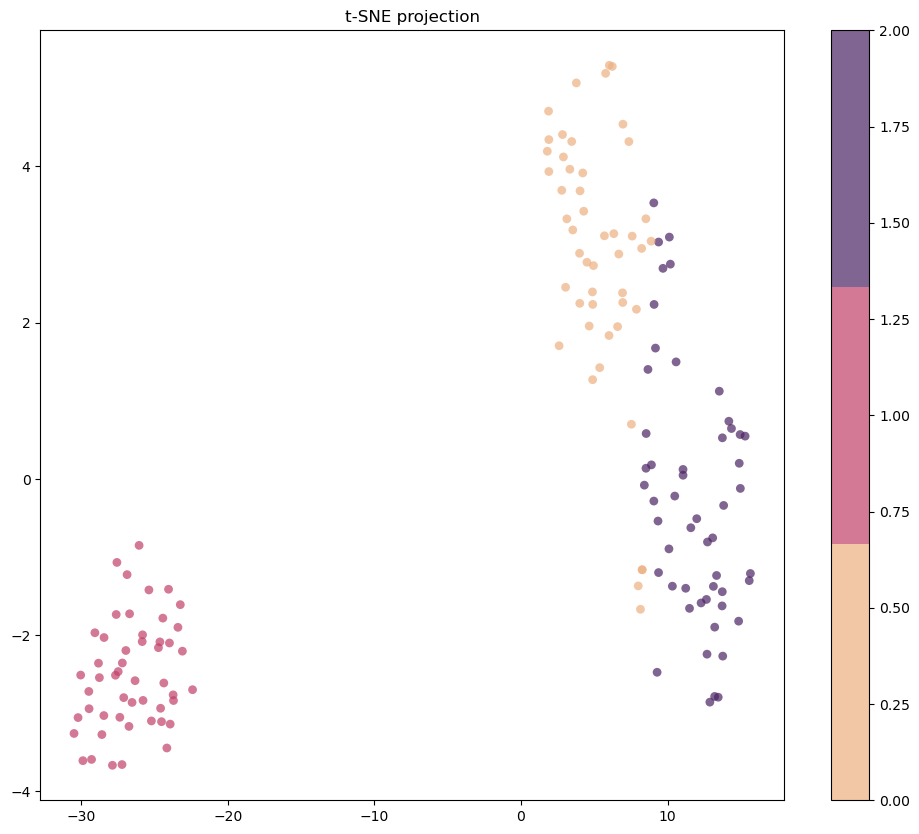

In [22]:
TSNEplot(pred_k)

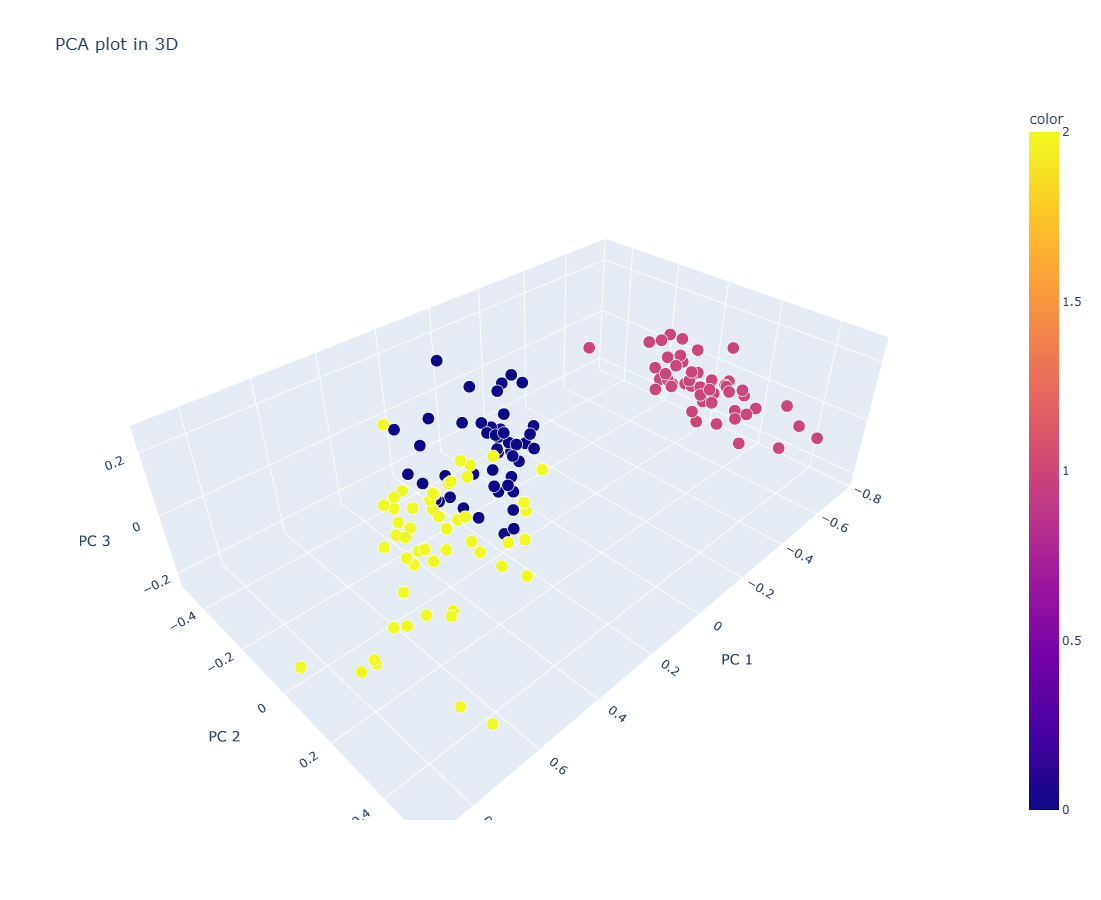

In [23]:
PCAplot3D(X, pred_k)

## Agglomerative Clustering by Ward

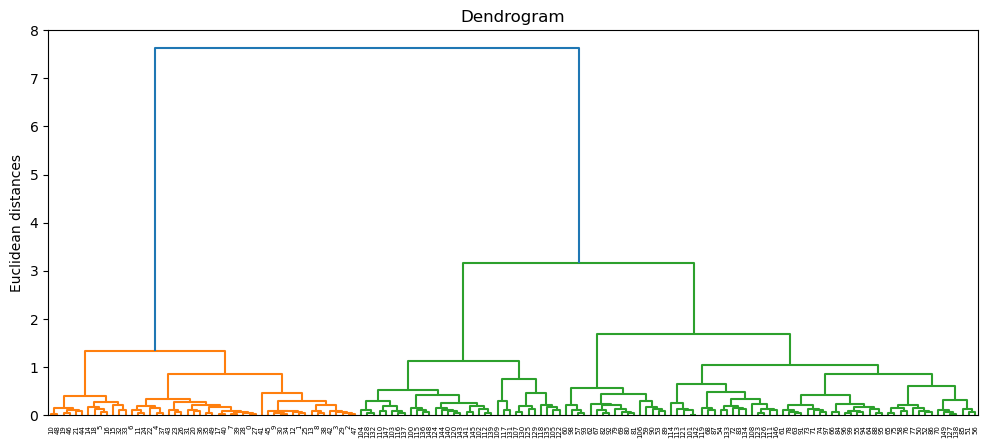

In [25]:
import scipy.cluster.hierarchy as sch
from matplotlib import pyplot
pyplot.figure(figsize=(12, 5))
dendrogram = sch.dendrogram(sch.linkage(X, method = 'ward'))
plt.title('Dendrogram')
plt.ylabel('Euclidean distances')
plt.show()

In [26]:
clustering_ward = AgglomerativeClustering(3).fit(X)
pred_ward = clustering_ward.labels_

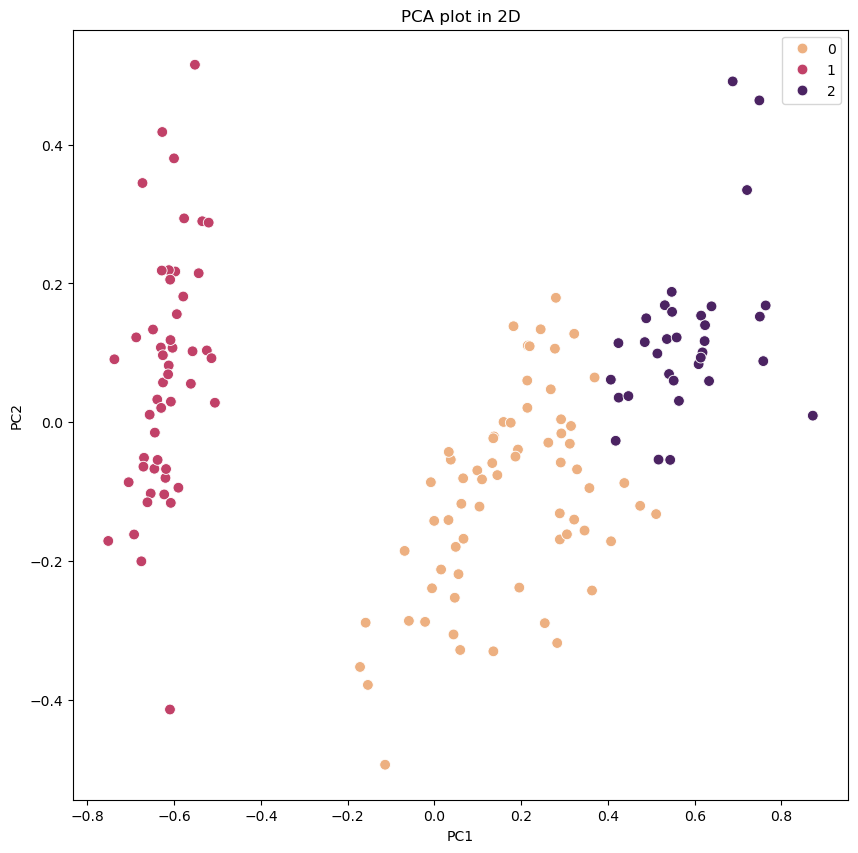

In [27]:
fig = plt.figure(figsize=(10, 10))
sns.scatterplot(x = principal_df.iloc[:,0], 
                y = principal_df.iloc[:,1], 
                hue = pred_ward, 
                palette="flare", 
                s=60)
plt.title('PCA plot in 2D')
plt.xlabel('PC1')
plt.ylabel('PC2');

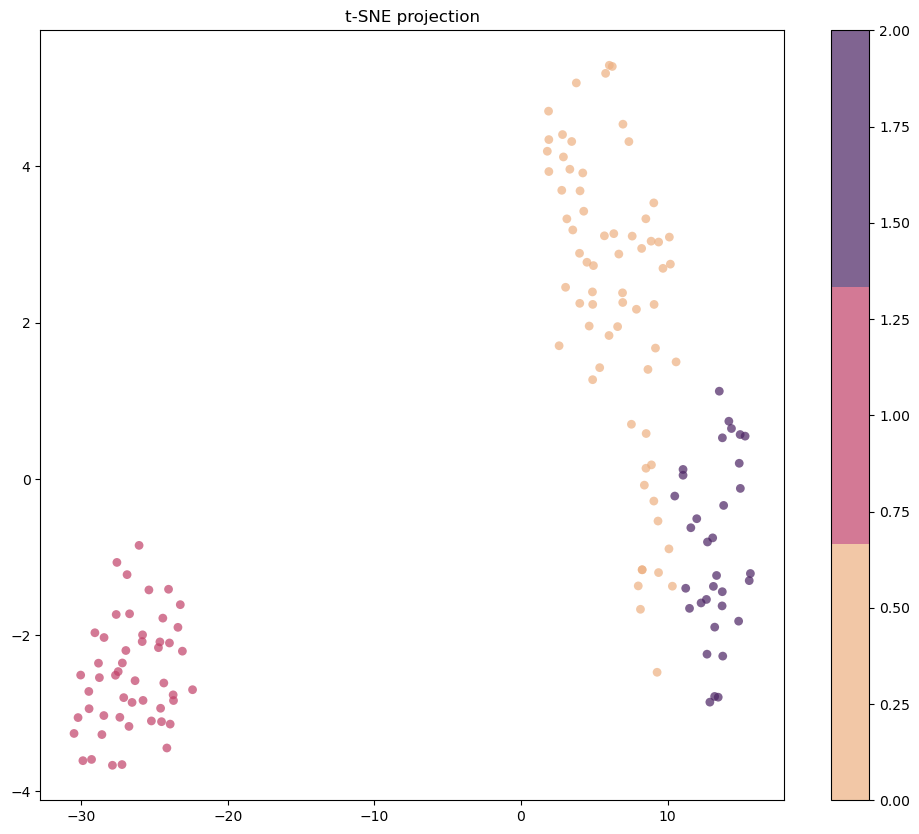

In [28]:
TSNEplot(pred_ward)

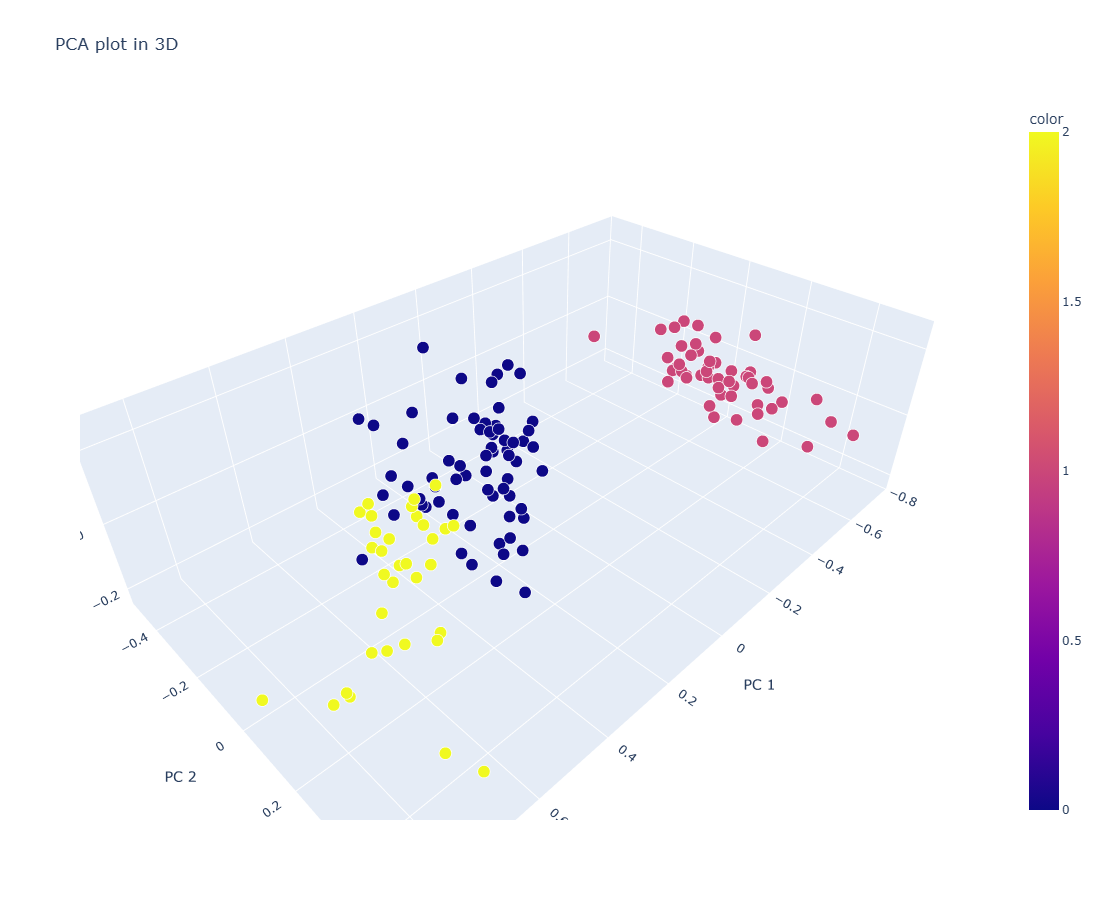

In [29]:
PCAplot3D(X, pred_ward)

## Spectral Clustering

In [31]:
clustering_sp = SpectralClustering(3).fit(X)
pred_sp = clustering_sp.labels_

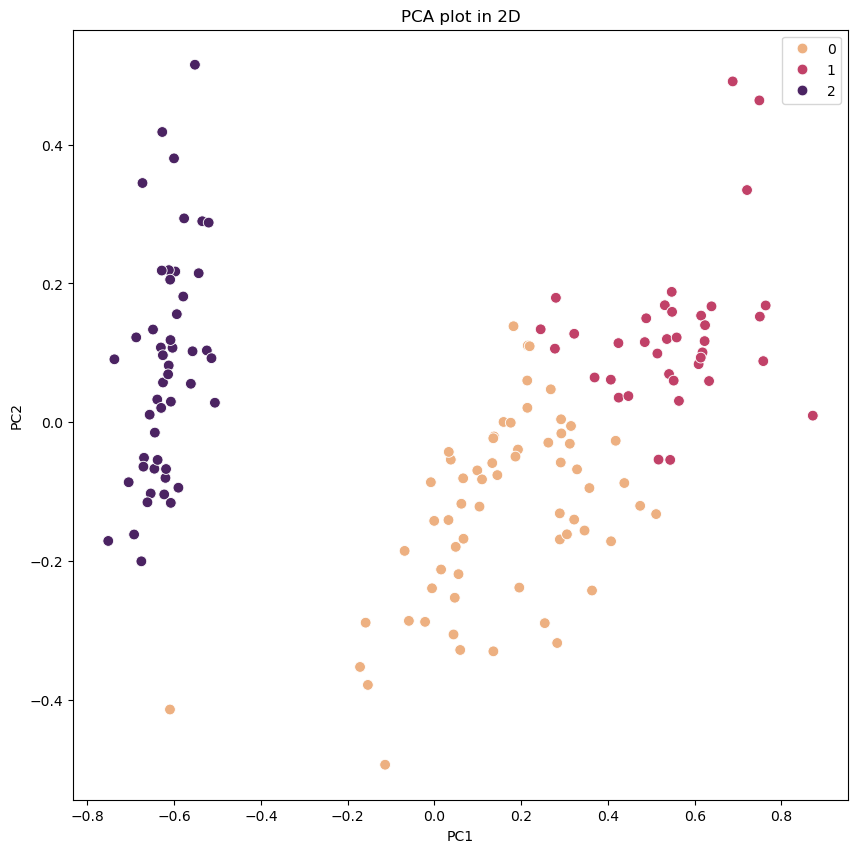

In [32]:
fig = plt.figure(figsize=(10, 10))
sns.scatterplot(x = principal_df.iloc[:,0], 
                y = principal_df.iloc[:,1], 
                hue = pred_sp, 
                palette="flare", 
                s=60)
plt.title('PCA plot in 2D')
plt.xlabel('PC1')
plt.ylabel('PC2');

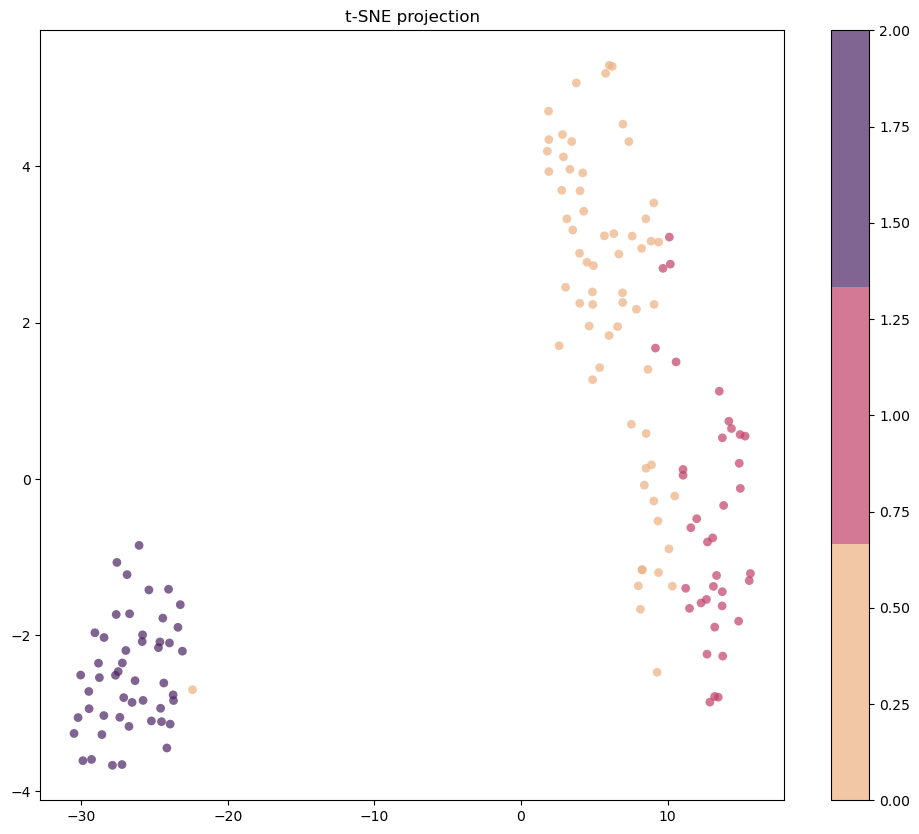

In [33]:
TSNEplot(pred_sp)

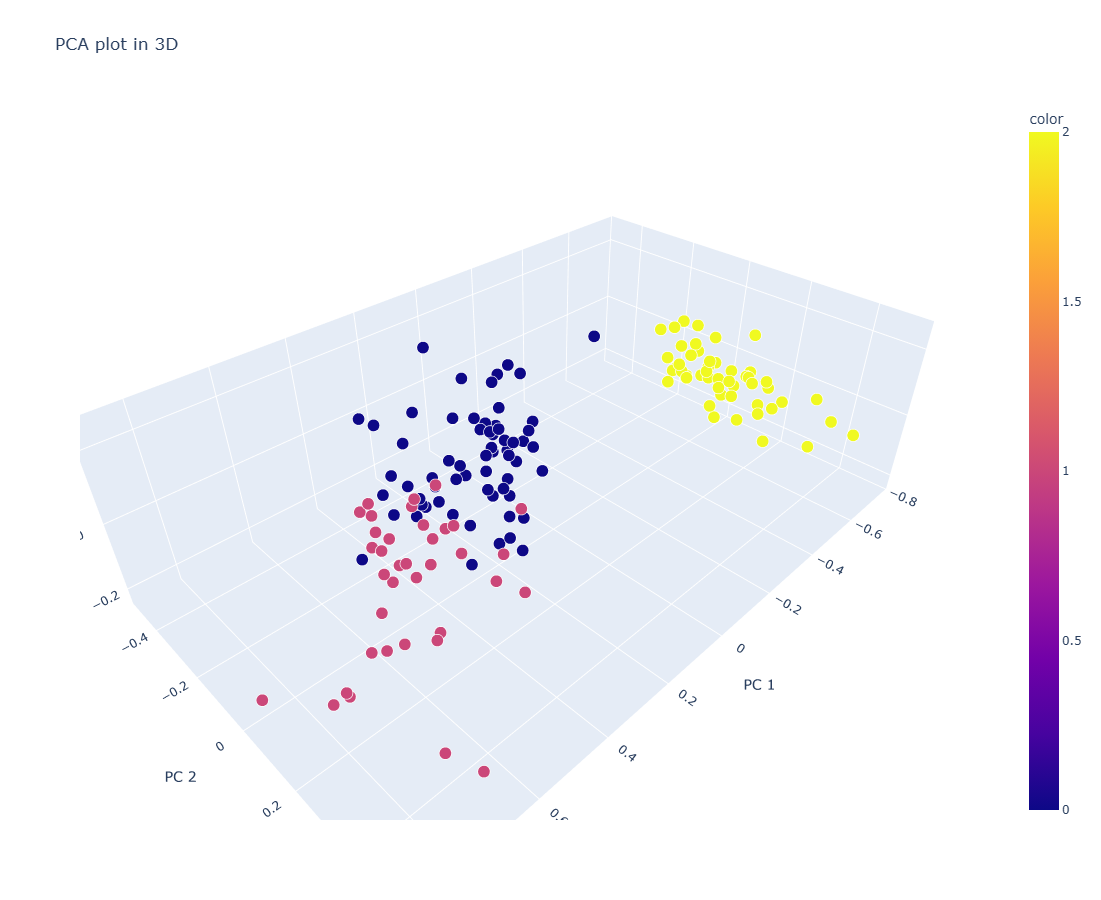

In [34]:
PCAplot3D(X, pred_sp)

## Сравнение реальных и предсказанных кластеров

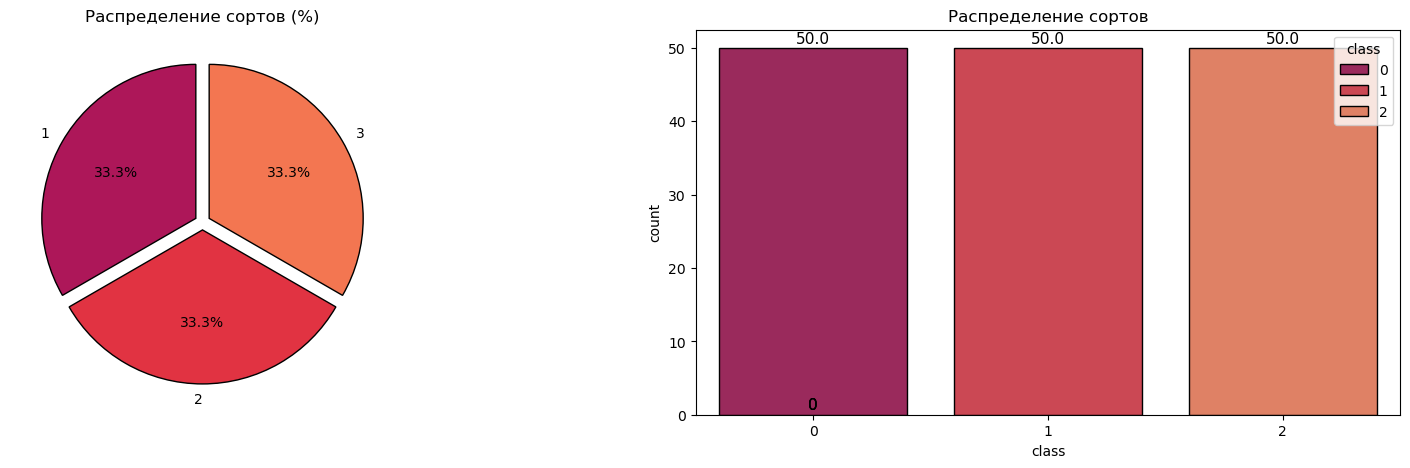

In [36]:
l = list(df_iris_v2['class'].value_counts())
sumLenn = sum(l)
proc = [l[1] / sumLenn * 100, l[0] / sumLenn * 100, l[2] / sumLenn * 100]
colors1 = sns.color_palette("rocket")[2:5]


fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (20, 5))
plt.subplot(1, 2, 1)
plt.pie(proc, labels = ['1', '2', '3'], 
        autopct = '%1.1f%%', 
        startangle = 90,
        explode = (0.05,0.05, 0.05), 
        colors = colors1, 
        wedgeprops = {'edgecolor' : 'black','antialiased' : True})
plt.title('Распределение сортов (%)')

plt.subplot(1, 2, 2)
ax = sns.countplot(x = df_iris_v2['class'], 
                   hue = df_iris_v2['class'], 
                   palette = colors1, 
                   edgecolor = "black" )
for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 0.7,\
            rect.get_height() , horizontalalignment='center', fontsize = 11)
plt.title('Распределение сортов');

## Rand Score

In [37]:
rs_k = rand_score(kmeans.labels_, y) 
rs_ward = rand_score(pred_ward, y)
rs_sp = rand_score(pred_sp, y)

print('\nK-Means')
print('_'*45 + '\n')
print(" rand_score = {} \n\n {} из 178 предсказано верно \n\n\n\n".format(rs_k, rs_k * 178))


print('Agglomerative Clustering')
print('_'*45 + '\n')
print(" rand_score = {} \n\n {} из 178 предсказано верно \n\n\n\n".format(rs_ward, rs_ward * 178))


print('Spectral Clustering')
print('_'*45 + '\n')
print(" rand_score = {} \n\n {} из 178 предсказано верно \n".format(rs_sp, rs_sp * 178))


K-Means
_____________________________________________

 rand_score = 0.6828635346756152 

 121.54970917225951 из 178 предсказано верно 




Agglomerative Clustering
_____________________________________________

 rand_score = 0.6562863534675615 

 116.81897091722594 из 178 предсказано верно 




Spectral Clustering
_____________________________________________

 rand_score = 0.6670246085011186 

 118.7303803131991 из 178 предсказано верно 



По метрике rand score мы види, что модели неплохо предсказывают, но проблема данной метрики, что она оценивает приближённо. Поэтому нужно рассмотреть ещё одну метрику.

## Изменённый Accuracy Score

In [38]:
y = y*10

In [149]:
def ACCURACY_SCORE_MY_SOLUTION(pred, R, v):
    
    diff = y - pred
    bb_data = pd.DataFrame(pred.copy())
    diff = diff.apply(lambda x: 1 if (x in [v[0] - R[0], v[1] - R[1], v[2] - R[2]]) else 0)
    
    
    bb_data.replace(to_replace=R[0], value=v[0], inplace=True)
    bb_data.replace(to_replace=R[1], value=v[1], inplace=True)
    bb_data.replace(to_replace=R[2], value=v[2], inplace=True)

    acc_k = accuracy_score(bb_data, y) 
    print(" accuracy_score = {} \n\n {} значений из {} предсказано верно \n\n\n\n".format(acc_k, acc_k * df_iris.shape[0], df_iris.shape[0]))
    
    
    principal_df = pd.DataFrame(data = PCA(n_components=2).fit_transform(X))
    components = PCA(n_components=3).fit_transform(X)

    
    fig = plt.figure(figsize=(10, 10))
    sns.scatterplot(x = principal_df.iloc[:,0], y = principal_df.iloc[:,1], hue = diff, palette=['#FF0000', '#1E90FF' ], s=90)
    plt.title('PCA график ошибок 2D')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    
    
    fig11 = px.scatter_3d(
    components, x=0, y=1, z=2, color=diff, size=0.1*np.ones(len(X)), opacity = 1,
    title='PCA график ошибок 3D',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'},
    width=900, height=900)
    fig11.show()

## K-Means

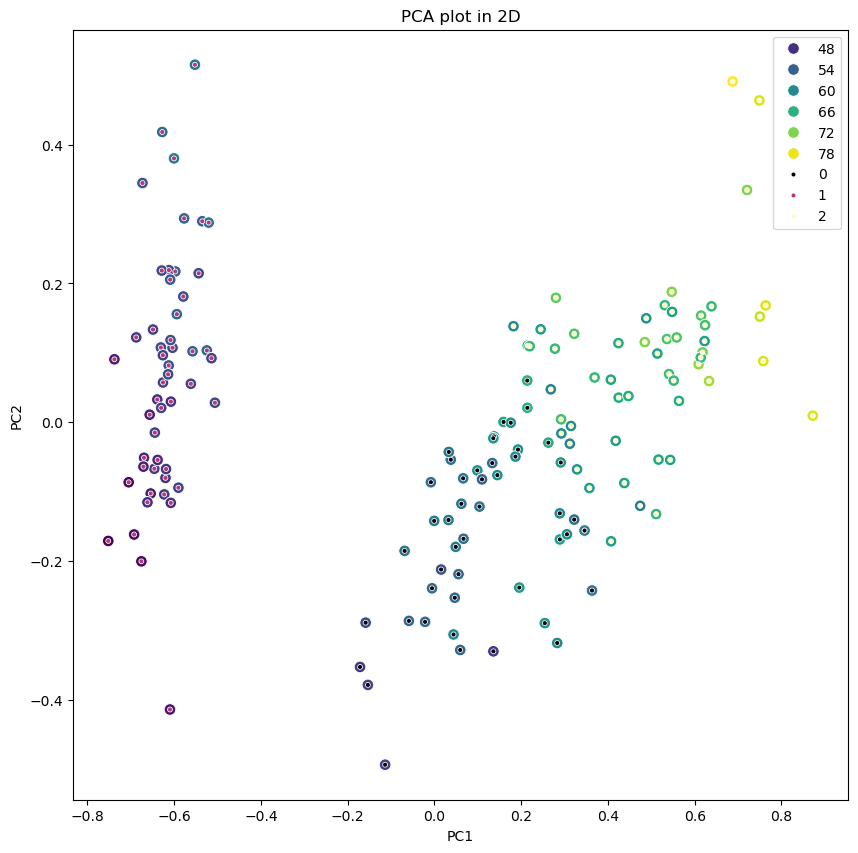

In [152]:
principal_df = pd.DataFrame(data = PCA(n_components=2).fit_transform(X))

fig = plt.figure(figsize=(10, 10))

sns.scatterplot(x = principal_df.iloc[:,0], 
                y = principal_df.iloc[:,1], 
                hue = y,
                palette="viridis", 
                s=70)
sns.scatterplot(x = principal_df.iloc[:,0], 
                y = principal_df.iloc[:,1], 
                hue = kmeans.labels_, 
                palette="magma", 
                marker=".", 
                s=50)

plt.title('PCA plot in 2D')
plt.xlabel('PC1')
plt.ylabel('PC2');

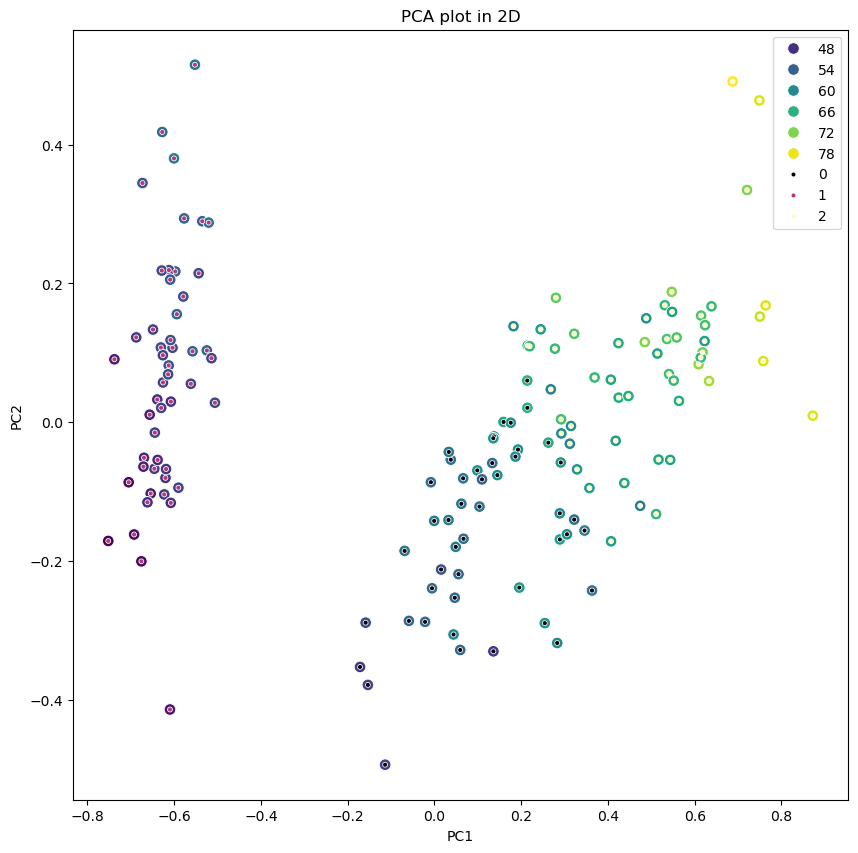

In [153]:
principal_df = pd.DataFrame(data = PCA(n_components=2).fit_transform(X))

fig = plt.figure(figsize=(10, 10))

sns.scatterplot(x = principal_df.iloc[:,0], 
                y = principal_df.iloc[:,1], 
                hue = y,
                palette="viridis", 
                s=70)
sns.scatterplot(x = principal_df.iloc[:,0], 
                y = principal_df.iloc[:,1], 
                hue = kmeans.labels_, 
                palette="magma", 
                marker=".", 
                s=50)

plt.title('PCA plot in 2D')
plt.xlabel('PC1')
plt.ylabel('PC2');

 accuracy_score = 0.0 

 0.0 значений из 150 предсказано верно 






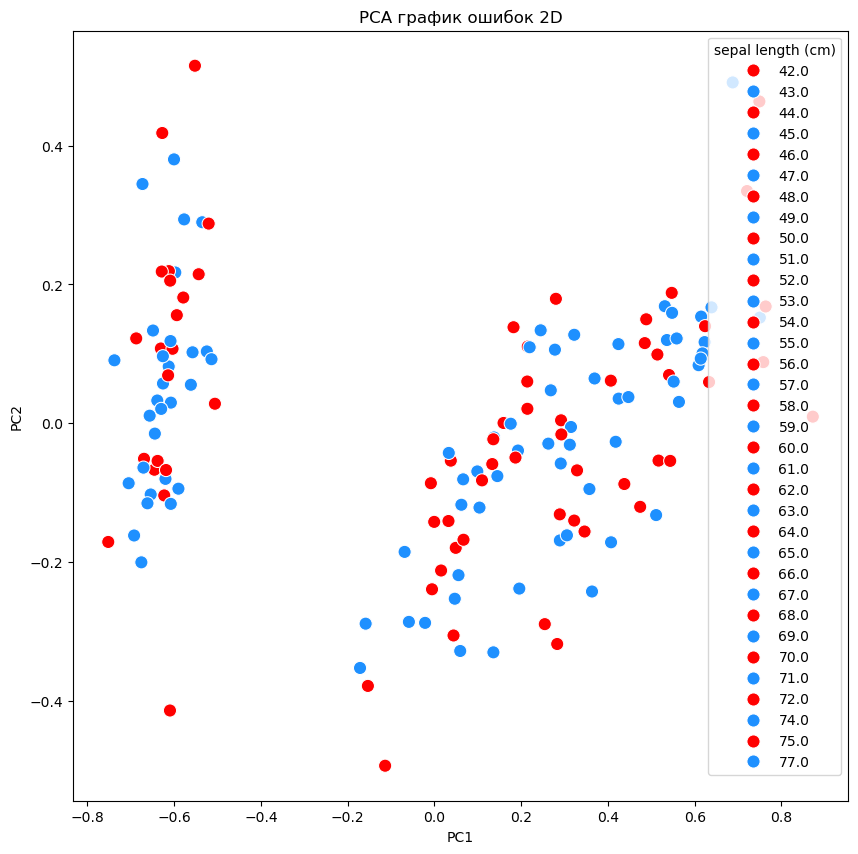

In [155]:
ACCURACY_SCORE_MY_SOLUTION(pred_k, [0,2,1], [10, 20, 30])

## Agglomerative Clustering by Ward

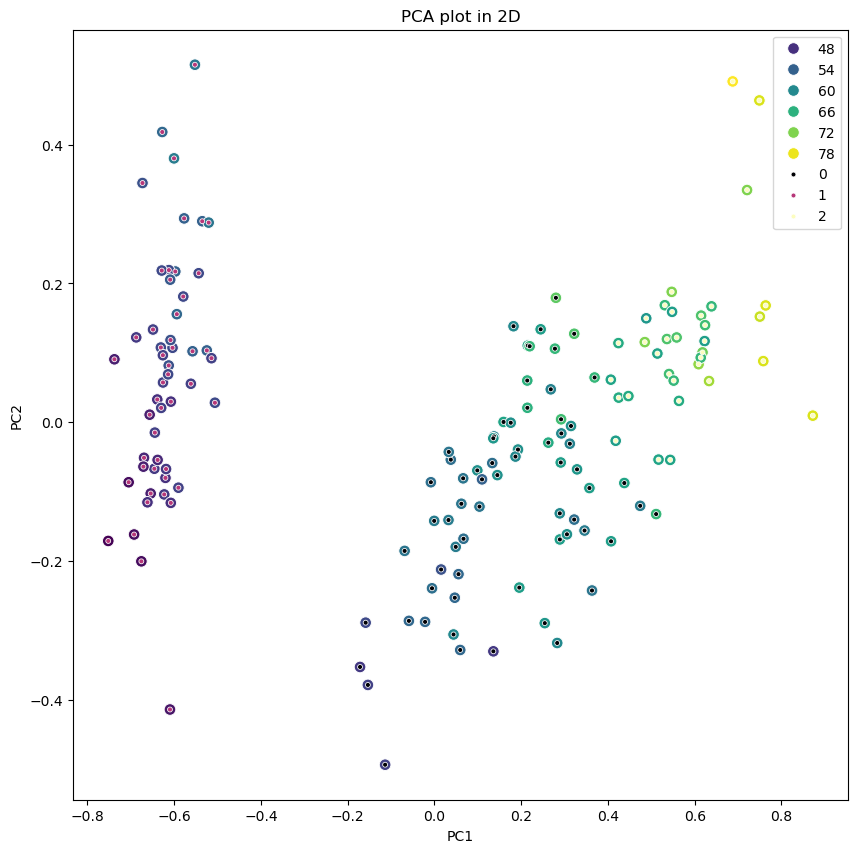

In [159]:
principal_df = pd.DataFrame(data = PCA(n_components=2).fit_transform(X))

fig = plt.figure(figsize=(10, 10))

sns.scatterplot(x = principal_df.iloc[:,0], 
                y = principal_df.iloc[:,1], 
                hue = y, 
                palette="viridis", 
                s=70)
sns.scatterplot(x = principal_df.iloc[:,0], 
                y = principal_df.iloc[:,1], 
                hue = pred_ward, 
                palette="magma", 
                marker=".", s=50)

plt.title('PCA plot in 2D')
plt.xlabel('PC1')
plt.ylabel('PC2');

 accuracy_score = 0.0 

 0.0 значений из 150 предсказано верно 






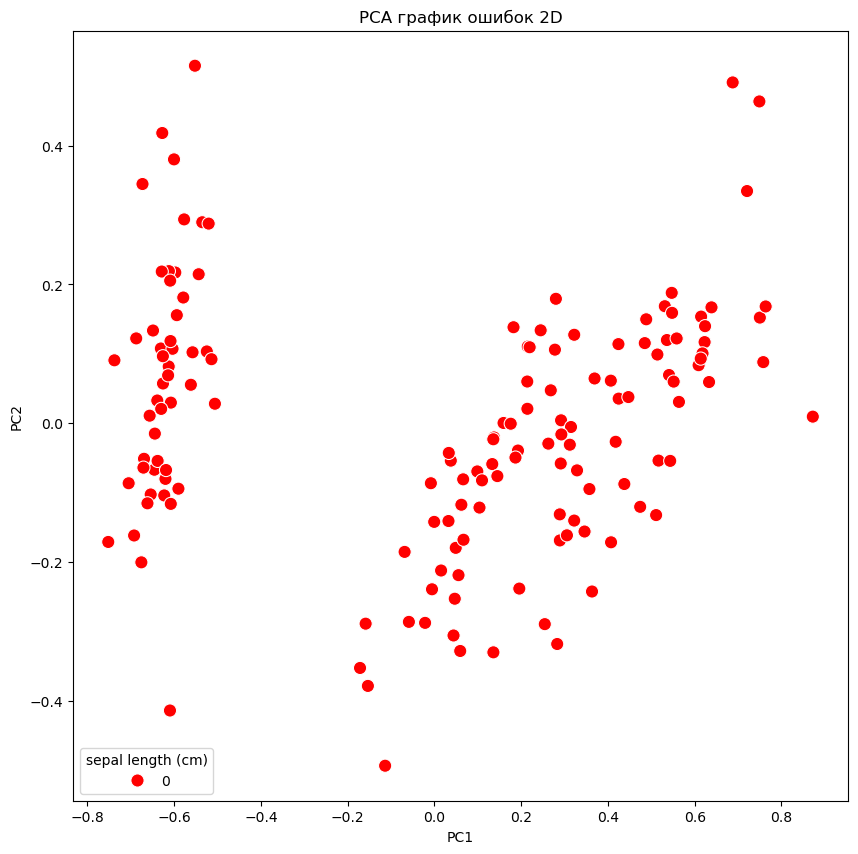

In [128]:
ACCURACY_SCORE_MY_SOLUTION(pred_ward, [2,0,1], [10, 20, 30])

## Spectral Clustering

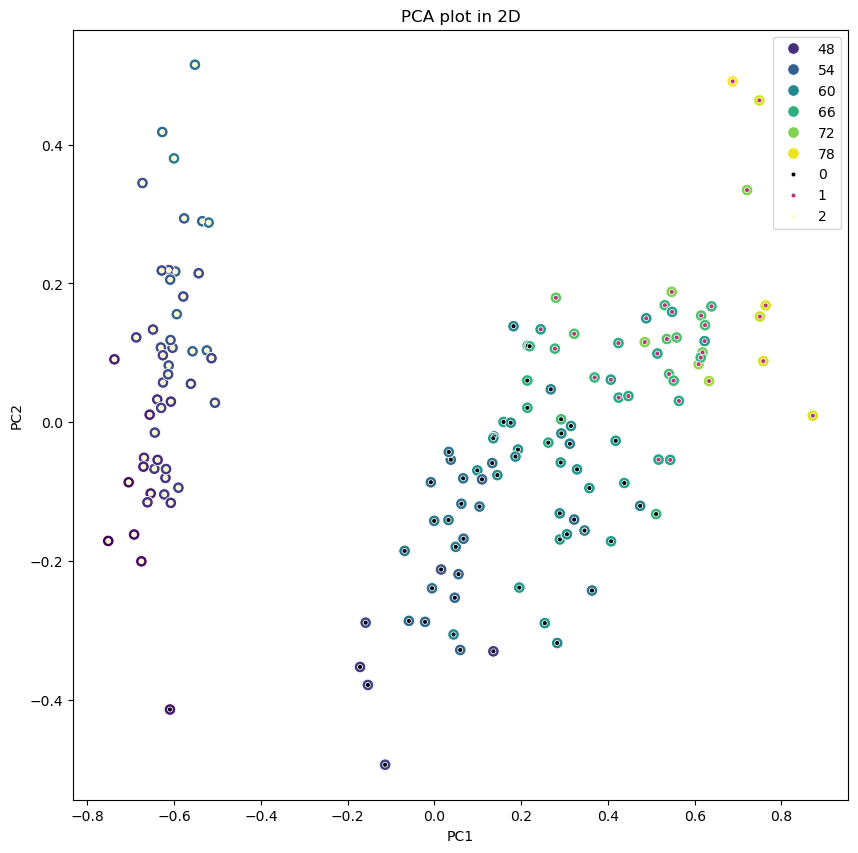

In [131]:
principal_df = pd.DataFrame(data = PCA(n_components=2).fit_transform(X))

fig = plt.figure(figsize=(10, 10))

sns.scatterplot(x = principal_df.iloc[:,0], 
                y = principal_df.iloc[:,1], 
                hue = y, 
                palette="viridis", 
                s=70)
sns.scatterplot(x = principal_df.iloc[:,0], 
                y = principal_df.iloc[:,1], 
                hue = pred_sp, 
                palette="magma", 
                marker=".", 
                s=50)

plt.title('PCA plot in 2D')
plt.xlabel('PC1')
plt.ylabel('PC2');

 accuracy_score = 0.0 

 0.0 значений из 150 предсказано верно 






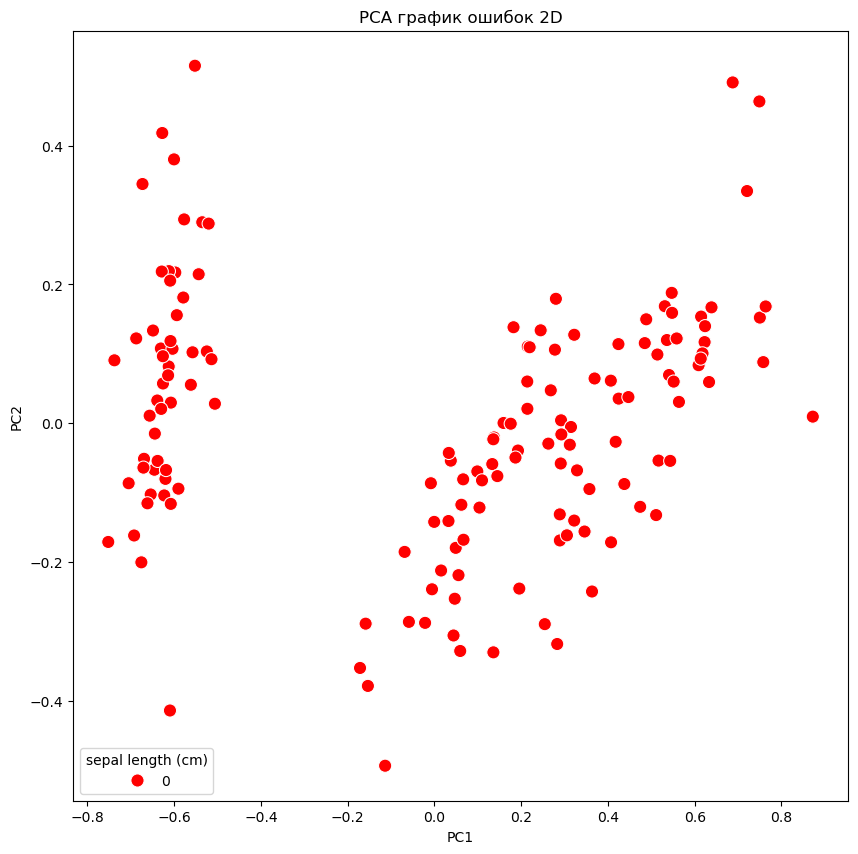

In [132]:
ACCURACY_SCORE_MY_SOLUTION(pred_sp, [2,0,1], [10, 20, 30])

## Распределение атрибутов реальных кластеров

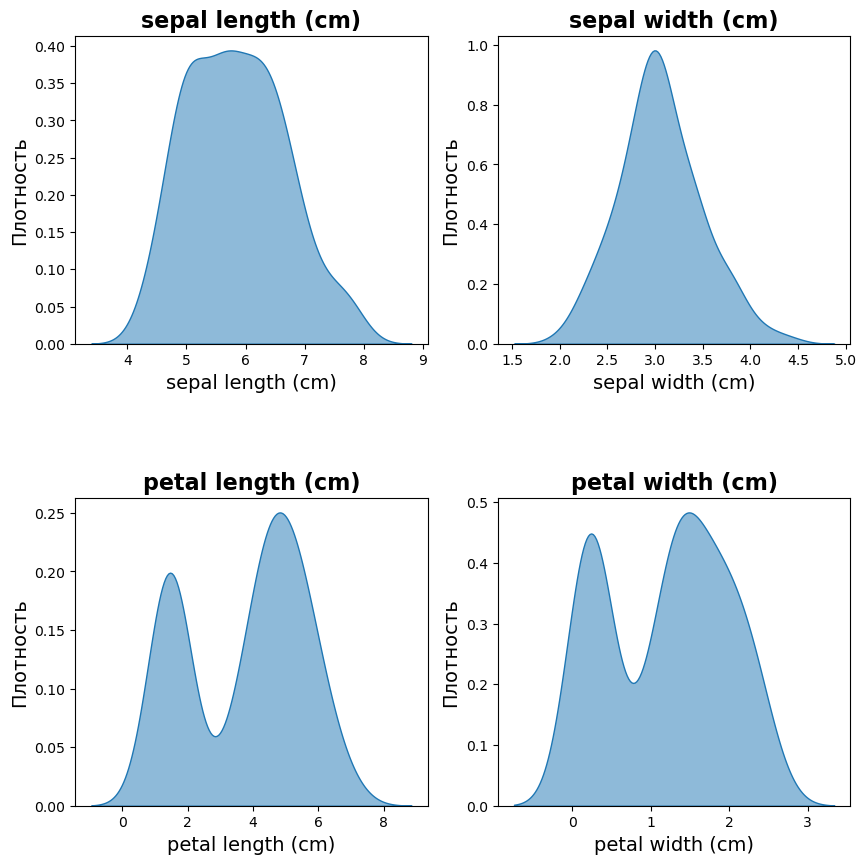

In [135]:
# Создаем матрицу графиков для визуализации распредления по каждой переменной
fig, axes = plt.subplots(2,2, figsize = (10,10))

# Расстояние между графиками
plt.subplots_adjust(hspace=0.5)

# Список значений признаков для цикла
columns = df_iris.columns

# Строим распределения (kdeplot) для каждого признака
for i, column in enumerate(columns):
    ax = axes[i // 2, i % 2]
    sns.kdeplot(data = df_iris,
                x = column,
                fill = True,
                alpha = 0.5,
                ax = ax)
    
    ax.set_title(column, fontweight = 'bold', fontsize = 16)
    ax.set_xlabel(column, fontsize = 14)
    ax.set_ylabel('Плотность', fontsize = 14)
    

plt.show()